# Imports

In [1]:
import numpy as np
import nibabel as nib
import lightning.pytorch as Lit
import matplotlib.pyplot as plt
import torch
import nrrd
import os
import re

%load_ext autoreload
%autoreload 2

# Data exploration

In [2]:
folder_path = "data\HaN-Seg\case_01"
files = [file for file in os.listdir(folder_path) if file.endswith(".nrrd")]
sample_file = files[4]

# read a nrdd file and print the header and shape
data, header = nrrd.read(os.path.join(folder_path, sample_file))

print(f"Example header of file '{sample_file}'\n")
for key in header.keys():
    print(key, ": ", header[key])

Example header of file 'case_01_OAR_A_Carotid_R.seg.nrrd'

type :  unsigned char
dimension :  3
space :  left-posterior-superior
sizes :  [1024 1024  202]
space directions :  [[0.55761719 0.         0.        ]
 [0.         0.55761719 0.        ]
 [0.         0.         2.        ]]
kinds :  ['domain', 'domain', 'domain']
encoding :  gzip
space origin :  [-285.5 -207.5 -759. ]


## Merge all the segmentation files into a single one and move them to the right folders

In [3]:
import shutil
import json
from utils.file_reading import merge_segmentations

# leave false if you have already done it once
merge_segmentations = False

data_folder = "data"
HaN_folder = "data/HaN-Seg"
imagesTr_folder = "data/imagesTr/"
labelsTr_folder = "data/labelsTr/"

if merge_segmentations:
    # copies the CT and MRI to the imagesTr folder and merges the segmentations to the labelsTr folder
    for case in os.listdir(HaN_folder):
        case_path = os.path.join(HaN_folder, case)
        if os.path.isdir(case_path):
            print(case_path)

            # copy the images to the imagesTr folder
            for file in os.listdir(case_path):
                if "IMG" in file:
                    shutil.copy(os.path.join(case_path, file), imagesTr_folder)

            # merge the labels and copy them to the labelsTr folder
            segmentation_files = [
                file for file in os.listdir(case_path) if "OAR" in file
            ]
            merged_segmentation, names_dict = merge_segmentations(
                case_path, segmentation_files
            )

            # save the merged segmentation in the labelsTr folder
            nrrd.write(
                os.path.join(labelsTr_folder, f"{case}_segmentation.nrrd"),
                merged_segmentation,
            )

    # save the names dictionary in a json file in the data folder
    with open(os.path.join(data_folder, "names_dict.json"), "w") as f:
        json.dump(names_dict, f, indent=4)

# Load an image and a label and plot them

In [4]:
from utils.file_reading import load_sample

ct, mri, seg = load_sample(1)

print(f"ct shape: {ct.shape}")
print(f"mri shape: {mri.shape}")
print(f"seg shape: {seg.shape}")

ct shape: (1024, 1024, 202)
mri shape: (512, 512, 83)
seg shape: (1024, 1024, 202)


In [5]:
from utils.plotting import plot_sample_from_dir

# plot a sample along all the planes
# plot_sample_from_dir(plane="a", case_number=1, slice_number=100)
# plot_sample_from_dir(plane="c", case_number=1, slice_number=500)
# plot_sample_from_dir(plane="s", case_number=1, slice_number=500)

# Trying transforms on data

In [6]:
from utils.file_reading import get_sample_paths
from utils.plotting import plot_all
import matplotlib.pyplot as plt
import numpy as np
import torchio as tio

ct_path, mri_path, seg_path = get_sample_paths(10)

subject = tio.Subject(
    ct=tio.ScalarImage(ct_path),
    mri=tio.ScalarImage(mri_path),
    seg=tio.LabelMap(seg_path),
)

c:\Users\simon\anaconda3.gz\envs\torch-v2-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


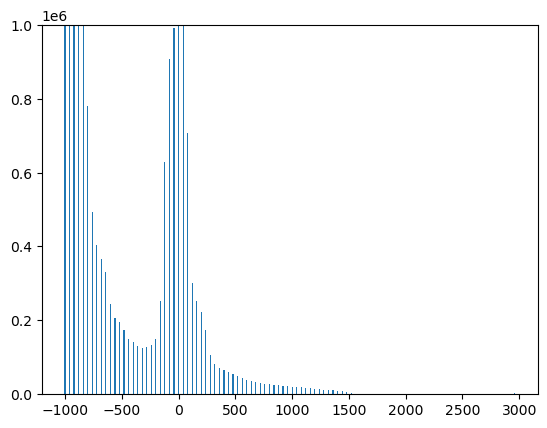

In [7]:
def hist_(data, bins=100, ylim=None, width=1):
    hist = np.histogram(data, bins=bins)

    plt.bar(hist[1][:-1], hist[0], width=width)

    if ylim is not None:
        plt.ylim(0, ylim)
    plt.show()


hist_(subject.ct.data, ylim=1e6, width=10)

## Rescale the intensities

In [8]:
rescaler = tio.RescaleIntensity((0, 1), percentiles=(0.5, 99.5))
scaled_subject = rescaler(subject)

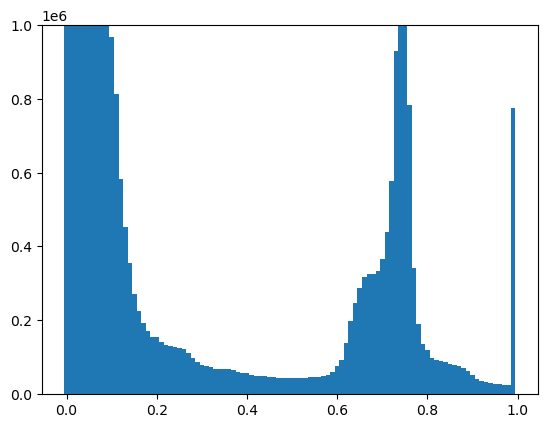

In [9]:
hist_(scaled_subject.ct.data, ylim=1e6, width=0.01)

## Change voxel spacing to save memory and put ToCanonical orientation

In [10]:
canonical_spacing_transform = tio.Compose(
    [
        tio.CopyAffine(target="ct", exclude="mri"),
        tio.ToCanonical(),
        tio.OneHot(include="seg"),
    ]
)

In [11]:
canonical_subject = canonical_spacing_transform(scaled_subject)

In [12]:
print(canonical_subject.ct)
print(canonical_subject.mri)
print(canonical_subject.seg)

ScalarImage(shape: (1, 1024, 1024, 143); spacing: (0.67, 0.67, 3.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 572.0 MiB)
ScalarImage(shape: (1, 512, 512, 144); spacing: (0.51, 0.51, 1.70); orientation: RAS+; dtype: torch.FloatTensor; memory: 144.0 MiB)
LabelMap(shape: (1, 1024, 1024, 143); spacing: (0.67, 0.67, 3.00); orientation: RAS+; dtype: torch.ByteTensor; memory: 143.0 MiB)


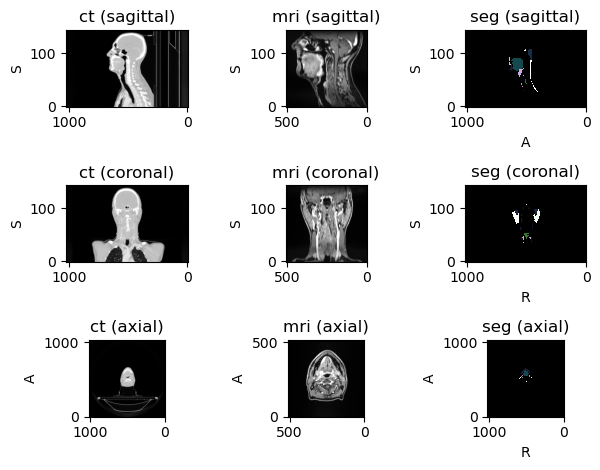

In [13]:
canonical_subject.plot()

## Apply some data augmentation transforms

In [22]:
augmentation_transform = tio.Compose(
    [   
        tio.RandomAffine(check_shape=False),
        tio.OneOf(
            {
                tio.RandomNoise(include="ct"): 0.5,
                tio.RandomBlur(include="ct"): 0.5,
            }
        ),        
        tio.RandomBiasField(p=0.2, include="ct"),
        tio.RandomGamma(p=0.2, include="ct"),
    ]
)

In [24]:
augmented_subject = augmentation_transform(canonical_subject)

In [ ]:
# final transform including all the above

transform = tio.Compose(
    [
        tio.RescaleIntensity((0, 1), percentiles=(0.5, 99.5)),

        tio.CopyAffine(target="ct", exclude="mri"),
        tio.ToCanonical(),
        tio.OneHot(include="seg"),

        tio.RandomAffine(check_shape=False),
        tio.OneOf(
            {
                tio.RandomNoise(include="ct"): 0.5,
                tio.RandomBlur(include="ct"): 0.5,
            }
        ),        
        tio.RandomBiasField(p=0.2, include="ct"),
        tio.RandomGamma(p=0.2, include="ct"),
    ]
)